# Objective: based on the information available in the dataset, try to predict whether or not an individual has sought treatment for a mental health condition.

# 1. Loading the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# preparation
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV

# models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
#from sklearn.feature_selection import SelectFromModel

# validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

C:\Users\Ossama\Anaconda3-4.2.0\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


#  2. Data preparation

In [2]:
# reading the data file and extracting general info from it
survey = pd.read_csv('survey.csv')
survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
Timestamp                    1259 non-null object
Age                          1259 non-null int64
Gender                       1259 non-null object
Country                      1259 non-null object
state                        744 non-null object
self_employed                1241 non-null object
family_history               1259 non-null object
treatment                    1259 non-null object
work_interfere               995 non-null object
no_employees                 1259 non-null object
remote_work                  1259 non-null object
tech_company                 1259 non-null object
benefits                     1259 non-null object
care_options                 1259 non-null object
wellness_program             1259 non-null object
seek_help                    1259 non-null object
anonymity                    1259 non-null object
leave                        1259 non-null obj

Only few columns ("state", "work_interfere", "comments") have null values.
<br>
However the "work_interfere" column will be our target column, and unfortunately 20% of its values are missing. We have to manage with these 80% values available.
<br>
Now let's look in detail at the content of all these columns if they need any cleaning.

In [3]:
survey.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [4]:
# missing data
missing_values_per_column = survey.isnull().sum().sort_values(ascending=False)
percentage_missing_values = 100*(survey.isnull().sum()/survey.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([missing_values_per_column, percentage_missing_values], \
                         axis=1, keys=['Number of missing values', 'Percentage of missing values'])
pmv = 'Percentage of missing values'
missing_data[pmv] = pd.Series(["{0:.2f}%".format(val) for val in missing_data[pmv]],index = missing_data.index)
missing_data

,Number of missing values,Percentage of missing values
comments,1095,86.97%
state,515,40.91%
work_interfere,264,20.97%
self_employed,18,1.43%
benefits,0,0.00%
Age,0,0.00%
Gender,0,0.00%
Country,0,0.00%
family_history,0,0.00%
treatment,0,0.00%


In [5]:
# removing columns not useful for our analysis
survey.drop(['comments','state','Timestamp'], axis= 1,inplace = True)

In [6]:
# the NaN values of the "self_employed" column will be filled with the largely dominant value: "No"
survey['self_employed'].fillna('No',inplace = True)
survey['self_employed'].value_counts()

No     1113
Yes     146
Name: self_employed, dtype: int64

In [7]:
survey['Gender'].value_counts()

Male                                              615
male                                              206
Female                                            121
M                                                 116
female                                             62
F                                                  38
m                                                  34
f                                                  15
Make                                                4
Male                                                3
Woman                                               3
Cis Male                                            2
Female                                              2
Man                                                 2
Female (trans)                                      2
cis-female/femme                                    1
Mail                                                1
A little about you                                  1
Guy (-ish) ^_^              

Clearly the "Gender" column needs cleaning. <br>
All these values will be replaced by either "Male" or "Female". <br>
If the answer is not clear the value will be replaced by "NaN".

In [8]:
male_str = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make",\
            "male ", "man","msle", "mail", "malr","cis man", "Cis Male", "cis male"]
trans_str = ["trans-female", "something kinda male?", "queer/she/they", \
             "non-binary","nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", \
             "male leaning androgynous", "guy (-ish) ^_^", "trans woman", "neuter",\
             "female (trans)", "queer", "ostensibly male, unsure what that really means"]           
female_str = ["cis female", "f", "female", "woman",  "femake", "female ",\
              "cis-female/femme", "female (cis)", "femail"]
for idx, val in survey['Gender'].iteritems():
    if str.lower(val) in male_str:
        survey['Gender'].replace(val, 'Male', inplace = True)
    elif str.lower(val) in female_str:
        survey['Gender'].replace(val, 'Female', inplace = True)
    else:
        survey['Gender'].replace(val, 'NaN', inplace = True)

In [9]:
survey['Gender'].value_counts()

Male      991
Female    247
NaN        21
Name: Gender, dtype: int64

In [10]:
survey['work_interfere'].fillna('Don\'t know', inplace = True)

In [11]:
survey['work_interfere'].value_counts()

Sometimes     465
Don't know    264
Never         213
Rarely        173
Often         144
Name: work_interfere, dtype: int64

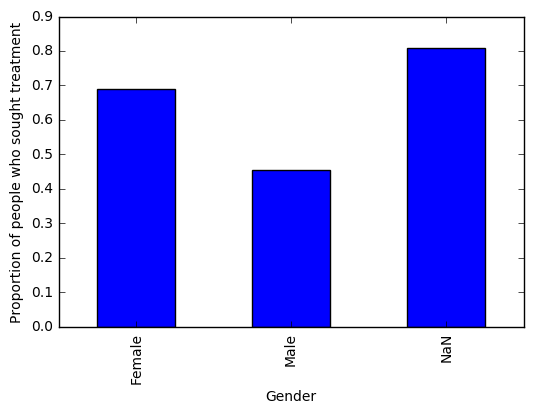

In [12]:
# changing "Yes" and "No" values by 1 and 0 (to make plots possible)
survey.replace(('Yes', 'No'), (1, 0), inplace=True)
gender_pivot = survey.pivot_table(index="Gender",values="treatment")
gender_pivot.plot.bar()
plt.ylabel("Proportion of people who sought treatment")
plt.show()

The results when the gender is unknown (with "NaN" value) are not relevant. <br>
Let's remove all rows where this value appears.

In [13]:
# replacing "NaN" string by np.nan for validity checking
survey['Gender'].replace(["NaN"], np.nan, inplace = True)
survey["Gender"].dropna(inplace=True)

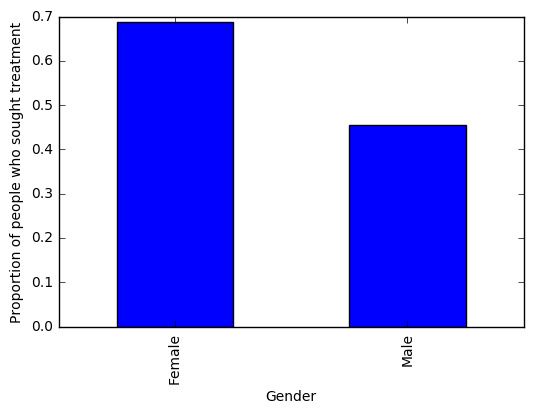

In [14]:
gender_pivot = survey.pivot_table(index="Gender",values="treatment")
gender_pivot.plot.bar()
plt.ylabel("Proportion of people who sought treatment")
plt.show()

It seems that more women than men are seeking treatment.

In [15]:
survey["Age"].describe()

count    1.259000e+03
mean     7.942815e+07
std      2.818299e+09
min     -1.726000e+03
25%      2.700000e+01
50%      3.100000e+01
75%      3.600000e+01
max      1.000000e+11
Name: Age, dtype: float64

Some values in the "Age" column are not realistic or completely no sense (like negative values or positive values above 150). <br>
Values between 18 and 73 will be filled by the median value of the column. <br> <br>
Also, as this column is a continuous feature, we'll separate it into a categorical feature by dividing it into ranges (this is called binning).

In [16]:
survey['Age'][survey['Age']<18] = survey['Age'].median()
survey['Age'][survey['Age']>73] = survey['Age'].median()

C:\Users\Ossama\Anaconda3-4.2.0\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [17]:
cut_points = [17,30,50,75]
label_names = ["Young Adult","Adult","Senior"]
survey["Age_categories"] = pd.cut(survey["Age"],cut_points,labels=label_names)

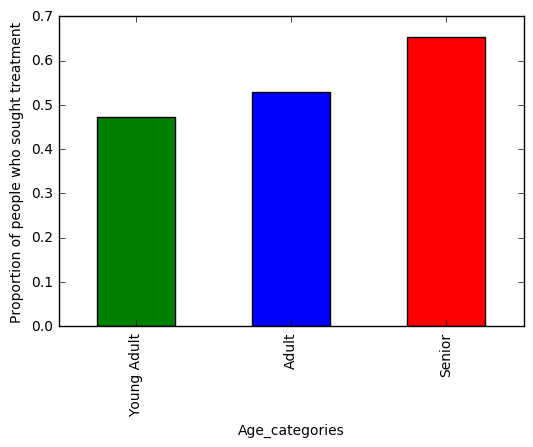

In [18]:
pivot = survey.pivot_table(index="Age_categories",values='treatment')
pivot.plot.bar(color ='gbr')
plt.ylabel("Proportion of people who sought treatment")
plt.show()

As our intuition would suggest, the older the person the more likely he/she would seek for treatment. <br> <br>
Most of the columns are non-numerical. We'll need to create dummy columns to make use of thes values in our ML models.

In [19]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [20]:
survey = create_dummies(survey,"Age_categories")
survey = create_dummies(survey,"Gender")

In [21]:
survey.columns

Index(['Age', 'Gender', 'Country', 'self_employed', 'family_history',
       'treatment', 'work_interfere', 'no_employees', 'remote_work',
       'tech_company', 'benefits', 'care_options', 'wellness_program',
       'seek_help', 'anonymity', 'leave', 'mental_health_consequence',
       'phys_health_consequence', 'coworkers', 'supervisor',
       'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence', 'Age_categories',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Gender_Female', 'Gender_Male'],
      dtype='object')

Now we'll try our first ML model (logistic regression) with two variables only: "Age_categories" and "Gender". <br>
We'll use the dummy columns just created above. <br>
Our metrics will be the accuracy (number of correct predictions / number of total predictions).

In [22]:
feature_cols = ['Age_categories_Young Adult', 'Age_categories_Adult', 'Age_categories_Senior',\
           'Gender_Female', 'Gender_Male']
X = survey[feature_cols]
y = survey.treatment
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

lr = LogisticRegression(solver ='lbfgs')
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [23]:
predictions = lr.predict(X_test)
accuracy = metrics.accuracy_score(y_test, predictions)
print('Logistic Regression with "Age_categories" and "Gender" variables')
print('Accuracy : {:.2f}'.format(accuracy))

Logistic Regression with "Age_categories" and "Gender" variables
Accuracy : 0.62


The first attempt gives quite poor accuracy. <br>
Let's see if we can improve with cross validation to train and test our model on different splits of our data, and then average the accuracy scores.

In [24]:
scores = cross_val_score(lr, X_test, y_test, cv=10)
accuracy = np.mean(scores)
print(scores)
print('Average accuracy with cross validation (10 folds) : {:.2f}'.format(accuracy))

[ 0.46153846  0.61538462  0.61538462  0.76923077  0.56        0.68        0.6
  0.6         0.625       0.625     ]
Average accuracy with cross validation (10 folds) : 0.62


Cross validation didn't improve accuracy at all.<br>
Let's try with more features.

In [25]:
# creating dummy columns for other columns
cols = ['family_history','work_interfere', 'care_options','benefits', 'wellness_program','anonymity',\
        'leave','mental_health_consequence', 'phys_health_consequence']
for column in cols:
    survey = create_dummies(survey,column)

In [26]:
survey.columns

Index(['Age', 'Gender', 'Country', 'self_employed', 'family_history',
       'treatment', 'work_interfere', 'no_employees', 'remote_work',
       'tech_company', 'benefits', 'care_options', 'wellness_program',
       'seek_help', 'anonymity', 'leave', 'mental_health_consequence',
       'phys_health_consequence', 'coworkers', 'supervisor',
       'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence', 'Age_categories',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Gender_Female', 'Gender_Male',
       'family_history_0', 'family_history_1', 'work_interfere_Don't know',
       'work_interfere_Never', 'work_interfere_Often', 'work_interfere_Rarely',
       'work_interfere_Sometimes', 'care_options_0', 'care_options_1',
       'care_options_Not sure', 'benefits_0', 'benefits_1',
       'benefits_Don't know', 'wellness_program_0', 'wellness_program_1',
       'wellness_program_Don't know', 'anonymit

In order to select the best-performing features, we need a way to measure which of our features are relevant to our target.<br>
One effective way is by training a logistic regression model using all of our features, and then looking at the coefficients of each feature.
<br><br>
The scikit-learn LogisticRegression class has an attribute in which coefficients are stored after the model is fit, LogisticRegression.coef_.<br>We first need to train our model, after which we can access this attribute.


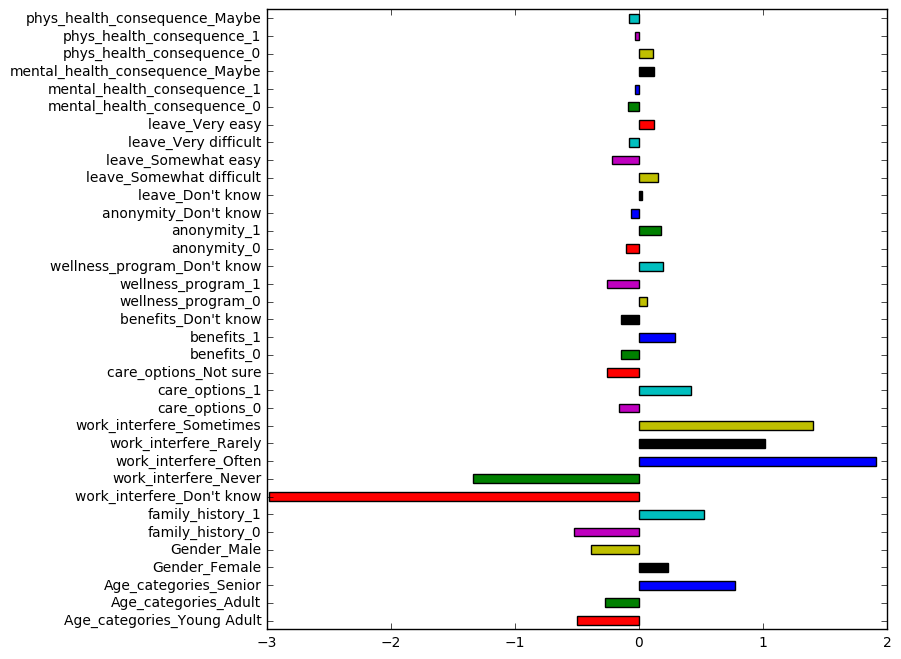

In [27]:
feature_cols = ['Age_categories_Young Adult', 'Age_categories_Adult',  'Age_categories_Senior',\
                'Gender_Female', 'Gender_Male','family_history_0', 'family_history_1', 'work_interfere_Don\'t know',\
                'work_interfere_Never', 'work_interfere_Often', 'work_interfere_Rarely',\
                'work_interfere_Sometimes', 'care_options_0', 'care_options_1',\
                'care_options_Not sure', 'benefits_0', 'benefits_1',\
                'benefits_Don\'t know', 'wellness_program_0', 'wellness_program_1',\
                'wellness_program_Don\'t know', 'anonymity_0', 'anonymity_1',\
                'anonymity_Don\'t know', 'leave_Don\'t know', 'leave_Somewhat difficult',\
                'leave_Somewhat easy', 'leave_Very difficult', 'leave_Very easy',\
                'mental_health_consequence_0', 'mental_health_consequence_1',\
                'mental_health_consequence_Maybe', 'phys_health_consequence_0',\
                'phys_health_consequence_1', 'phys_health_consequence_Maybe']
X = survey[feature_cols]
y = survey.treatment
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
coefficients = lr.coef_

feature_importance = pd.Series(coefficients[0],
                               index=X_train[feature_cols].columns)
plt.figure(figsize=(8,8)) 
feature_importance.plot.barh(color='rgbkymc')
plt.show()

The plot we generated just above shows a range of both positive and negative values. Whether the value is positive or negative isn't as important in this case, relative to the magnitude of the value.<br>
To make things easier to interpret, we'll alter the plot to show all positive values, and have sorted the bars in order of size.

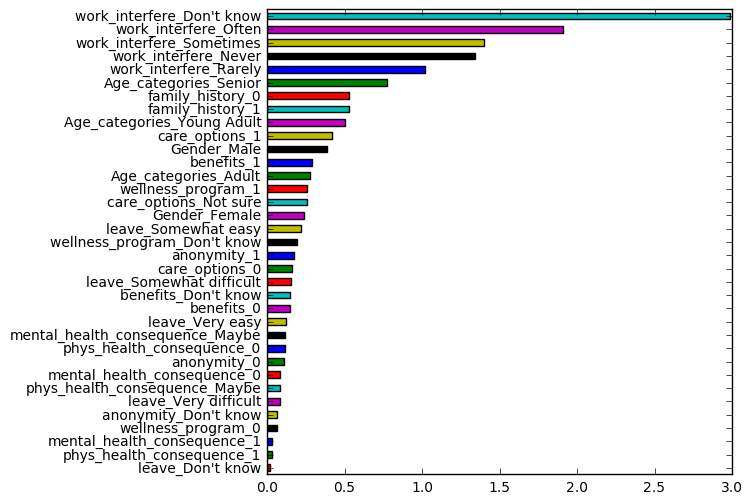

In [28]:
ordered_feature_importance = feature_importance.abs().sort_values()
plt.figure(figsize=(6,6))
ordered_feature_importance.plot.barh(color='rgbkymc')
plt.show()

In [29]:
scores = cross_val_score(lr, X_test, y_test, cv=10)
accuracy = np.mean(scores)
print(scores)
print(accuracy)

[ 0.76923077  0.73076923  0.92307692  0.84615385  0.8         0.84        0.8
  0.72        0.75        0.79166667]
0.79708974359


Now let's train a new model with the top n scores (n<8) and check our accuracy using cross validation.

In [30]:
def selectNScores(n):
    feature_cols = ordered_feature_importance.index[-n:]
    X = survey[feature_cols]
    y = survey.treatment
    # split X and y into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    lr = LogisticRegression(solver='lbfgs')
    lr.fit(X_train, y_train)
    
    scores = cross_val_score(lr, X_test, y_test, cv=10)
    accuracy = np.mean(scores)
    print('Average accuracy with the top {:d} feature(s) : {:.3f}'.format(n,accuracy))

In [31]:
for n in range(1,9):
    selectNScores(n)

Average accuracy with the top 1 feature(s) : 0.679
Average accuracy with the top 2 feature(s) : 0.679
Average accuracy with the top 3 feature(s) : 0.758
Average accuracy with the top 4 feature(s) : 0.806
Average accuracy with the top 5 feature(s) : 0.806
Average accuracy with the top 6 feature(s) : 0.806
Average accuracy with the top 7 feature(s) : 0.798
Average accuracy with the top 8 feature(s) : 0.798


It seems that there is an optimal number of features that would be 4 or 5. <br>
But actually, when we look at these top features, we find that they are all related to the "work_interfere" column of the original dataset. <br>
The 5th top feature is just the last dummy column among the 5 possible values of the original "work_interfere" column.
<br> <br>
This is an example of the dummy variable trap. So let's remove one of each of our dummy variables to reduce the collinearity in each.

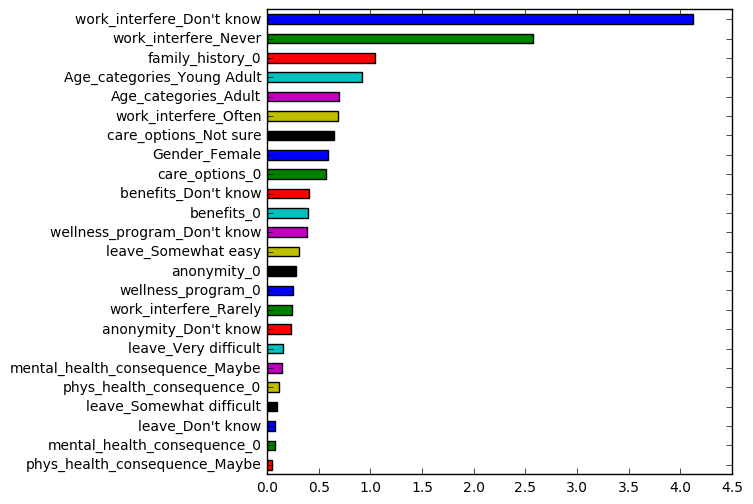

In [32]:
feature_cols = ['Age_categories_Young Adult', 'Age_categories_Adult',\
                'Gender_Female','family_history_0', 'work_interfere_Don\'t know',\
                'work_interfere_Never', 'work_interfere_Often', 'work_interfere_Rarely',\
                'care_options_0','care_options_Not sure', \
                'benefits_0', 'benefits_Don\'t know',\
                'wellness_program_0', 'wellness_program_Don\'t know',\
                'anonymity_0', 'anonymity_Don\'t know',\
                'leave_Don\'t know', 'leave_Somewhat difficult','leave_Somewhat easy', 'leave_Very difficult',\
                'mental_health_consequence_0', 'mental_health_consequence_Maybe',\
                'phys_health_consequence_0', 'phys_health_consequence_Maybe']
X = survey[feature_cols]
y = survey.treatment
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
coefficients = lr.coef_

feature_importance = pd.Series(coefficients[0],
                               index=X_train[feature_cols].columns)
ordered_feature_importance = feature_importance.abs().sort_values()
plt.figure(figsize=(6,6))
ordered_feature_importance.plot.barh(color='rgbkymc')
plt.show()

In [33]:
scores = cross_val_score(lr, X_test, y_test, cv=10)
accuracy = np.mean(scores)
print(scores)
print(accuracy)

[ 0.76923077  0.76923077  0.96153846  0.84615385  0.84        0.84        0.8
  0.72        0.75        0.75      ]
0.804615384615


In [34]:
for n in range(1,20):
    selectNScores(n)

Average accuracy with the top 1 feature(s) : 0.679
Average accuracy with the top 2 feature(s) : 0.806
Average accuracy with the top 3 feature(s) : 0.806
Average accuracy with the top 4 feature(s) : 0.806
Average accuracy with the top 5 feature(s) : 0.806
Average accuracy with the top 6 feature(s) : 0.806
Average accuracy with the top 7 feature(s) : 0.809
Average accuracy with the top 8 feature(s) : 0.814
Average accuracy with the top 9 feature(s) : 0.797
Average accuracy with the top 10 feature(s) : 0.793
Average accuracy with the top 11 feature(s) : 0.801
Average accuracy with the top 12 feature(s) : 0.797
Average accuracy with the top 13 feature(s) : 0.778
Average accuracy with the top 14 feature(s) : 0.778
Average accuracy with the top 15 feature(s) : 0.778
Average accuracy with the top 16 feature(s) : 0.782
Average accuracy with the top 17 feature(s) : 0.805
Average accuracy with the top 18 feature(s) : 0.801
Average accuracy with the top 19 feature(s) : 0.793


In [35]:
ordered_feature_importance[-8:]

Gender_Female                 0.586833
care_options_Not sure         0.646085
work_interfere_Often          0.684490
Age_categories_Adult          0.699440
Age_categories_Young Adult    0.921201
family_history_0              1.046082
work_interfere_Never          2.574896
work_interfere_Don't know     4.124284
dtype: float64

By avoiding the dummy variable trap, we find a different optimum set of features which seems to make more sense. <br>
Indeed, previously the optimum set was only consisting of values taken by the "work_interfere" column. <br>
Now we have a larger variety of original variables that enable to maximise the performance of our ML model. <br> <br>

For performance comparison, let's try now to select the most relevant features automatically. An alternate method is to use one of scikit-learn's inbuilt feature selection classes. We will be using the feature_selection.RFECV class which performs recursive feature elimination with cross-validation. <br>

The RFECV class starts by training a model using all features and scores it using cross validation. It then uses the logit coefficients to eliminate the least important feature, and trains and scores a new model. At the end, the class looks at all the scores, and selects the set of features which scored highest.

In [36]:
feature_cols = ['Age_categories_Young Adult', 'Age_categories_Adult',\
                'Gender_Female','family_history_0', 'work_interfere_Don\'t know',\
                'work_interfere_Never', 'work_interfere_Often', 'work_interfere_Rarely',\
                'care_options_0','care_options_Not sure', \
                'benefits_0', 'benefits_Don\'t know',\
                'wellness_program_0', 'wellness_program_Don\'t know',\
                'anonymity_0', 'anonymity_Don\'t know',\
                'leave_Don\'t know', 'leave_Somewhat difficult','leave_Somewhat easy', 'leave_Very difficult',\
                'mental_health_consequence_0', 'mental_health_consequence_Maybe',\
                'phys_health_consequence_0', 'phys_health_consequence_Maybe']
X = survey[feature_cols]
y = survey.treatment
lr = LogisticRegression(solver='lbfgs')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

lr = LogisticRegression(solver='lbfgs')
selector = RFECV(lr,cv=10)
selector.fit(X,y)

#we can use the RFECV.support_ attribute to access a boolean mask of True and False values
#which we can use to generate a list of optimized columns
optimized_columns = X.columns[selector.support_]

In [37]:
optimized_columns

Index(['Age_categories_Young Adult', 'Age_categories_Adult', 'Gender_Female',
       'family_history_0', 'work_interfere_Don't know', 'work_interfere_Never',
       'work_interfere_Often', 'work_interfere_Rarely', 'care_options_0',
       'care_options_Not sure', 'benefits_0', 'benefits_Don't know',
       'wellness_program_Don't know', 'anonymity_0', 'anonymity_Don't know',
       'leave_Somewhat difficult', 'leave_Somewhat easy'],
      dtype='object')

In [38]:
X = survey[optimized_columns]
y = survey.treatment
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [39]:
scores = cross_val_score(lr, X, y, cv=10)
accuracy = np.mean(scores)
print(scores)
print('Average accuracy with recursive feature elimination : {:.3f}'.format(accuracy))

[ 0.81889764  0.85826772  0.84126984  0.83333333  0.84126984  0.81746032
  0.84920635  0.88        0.816       0.768     ]
Average accuracy with recursive feature elimination : 0.832


Beautiful ! We have improved the accuracy with recursive feature elimination, which shows that this tool is very powerful. <br><br>
Now, let's play with another ML algorithm: k-nearest neighbors algorithm.

In [40]:
# applying knn using the maximum number of features first
feature_cols = ['Age_categories_Young Adult', 'Age_categories_Adult',  'Age_categories_Senior',\
                'Gender_Female', 'Gender_Male','family_history_0', 'family_history_1', 'work_interfere_Don\'t know',\
                'work_interfere_Never', 'work_interfere_Often', 'work_interfere_Rarely',\
                'work_interfere_Sometimes', 'care_options_0', 'care_options_1',\
                'care_options_Not sure', 'benefits_0', 'benefits_1',\
                'benefits_Don\'t know', 'wellness_program_0', 'wellness_program_1',\
                'wellness_program_Don\'t know', 'anonymity_0', 'anonymity_1',\
                'anonymity_Don\'t know', 'leave_Don\'t know', 'leave_Somewhat difficult',\
                'leave_Somewhat easy', 'leave_Very difficult', 'leave_Very easy',\
                'mental_health_consequence_0', 'mental_health_consequence_1',\
                'mental_health_consequence_Maybe', 'phys_health_consequence_0',\
                'phys_health_consequence_1', 'phys_health_consequence_Maybe']
X = survey[feature_cols]
y = survey.treatment
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [41]:
knn = KNeighborsClassifier(n_neighbors=1)
scores = cross_val_score(knn, X, y, cv=10)
accuracy_knn = scores.mean()
print(scores)
print('Average accuracy with knn (1 neighbor) : {:.3f}'.format(accuracy_knn))

[ 0.75590551  0.75590551  0.82539683  0.73015873  0.69047619  0.71428571
  0.74603175  0.752       0.656       0.736     ]
Average accuracy with knn (1 neighbor) : 0.736


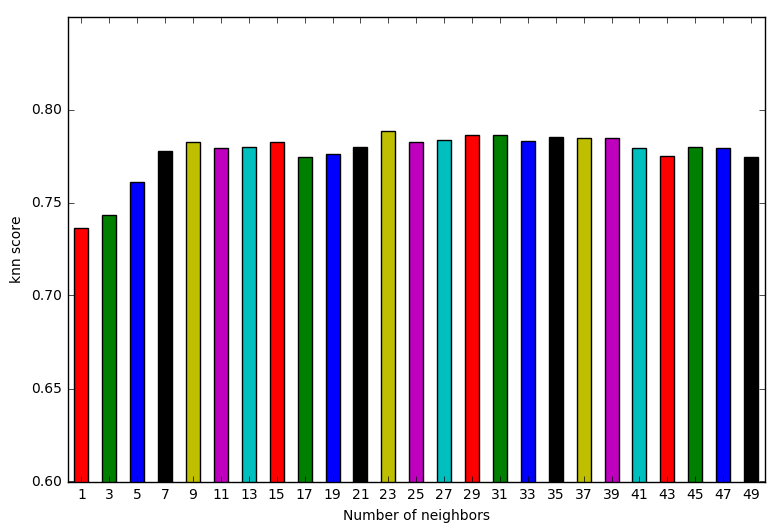

In [42]:
def plot_dict(dictionary):
    pd.Series(dictionary).plot.bar(figsize=(9,6),
                                   ylim=(0.6,0.85),rot=0,color='rgbkymc')
    plt.xlabel('Number of neighbors')
    plt.ylabel('knn score')
    plt.show()

knn_scores = dict()
for k in range(1,50,2):
    knn = KNeighborsClassifier(n_neighbors=k)

    scores = cross_val_score(knn, X, y, cv=10)
    accuracy_knn = scores.mean()
    knn_scores[k] = accuracy_knn
    
plot_dict(knn_scores)

Even with the optimum number of neighbors (23), the knn algorithm shows lower performance in comparison with logistic regression (accuracy never reaches 0.8). <br>
Let's go further with hyperparameter optimization to see if the knn can perform better.

In [43]:
# automating the process with GridSearch
hyperparameters = {
    "n_neighbors": range(1,50,2)
}
grid = GridSearchCV(knn, param_grid=hyperparameters, cv=10)
grid.fit(X, y)

print(grid.best_params_)

{'n_neighbors': 23}


In [44]:
# trying knn with other hyperparameters
hyperparameters = {
    "n_neighbors": range(1,50,2),
    "weights": ["distance", "uniform"],
    "algorithm": ['brute'],
    "p": [1,2]
}
knn = KNeighborsClassifier()
grid = GridSearchCV(knn,param_grid=hyperparameters,cv=10)

grid.fit(X, y)

print(grid.best_params_)
print(grid.best_score_)

{'algorithm': 'brute', 'n_neighbors': 45, 'weights': 'uniform', 'p': 1}
0.783161239079


Even grid search does not enable to obtain an accuracy higher than 0.8. <br>
Definitely knn is not the best model to use for this challenge.  <br> <br>
Let's try now random forests algorithm.

In [45]:
clf = RandomForestClassifier(random_state=1)
scores = cross_val_score(clf,X, y, cv=10)
accuracy_rf = scores.mean()
print('Average accuracy with random forests : {:.3f}'.format(accuracy_rf))

C:\Users\Ossama\Anaconda3-4.2.0\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Ossama\Anaconda3-4.2.0\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Ossama\Anaconda3-4.2.0\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Ossama\Anaconda3-4.2.0\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Ossama\Anaconda3-4.2.0\lib\site-package

Average accuracy with random forests : 0.797


C:\Users\Ossama\Anaconda3-4.2.0\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Ossama\Anaconda3-4.2.0\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Ossama\Anaconda3-4.2.0\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


A cross-validation with random forest regression (without hyperparameter optimisation at the moment) shows better performance than the most optimised knn model. <br>
Let's see how grid search can improve the accuracy.

In [46]:
hyperparameters = {"criterion": ["entropy", "gini"],
                   "max_depth": [5, 10],
                   "max_features": ["log2", "sqrt"],
                   "min_samples_leaf": [1, 5],
                   "min_samples_split": [3, 5],
                   "n_estimators": [6, 9]
                    }

clf = RandomForestClassifier()
grid = GridSearchCV(clf,param_grid=hyperparameters,cv=10)

grid.fit(X, y)

best_params = grid.best_params_
best_score = grid.best_score_
print(best_params)
print('Best score with random forests : {:.3f}'.format(best_score))

{'min_samples_split': 5, 'min_samples_leaf': 5, 'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 5, 'n_estimators': 9}
Best score with random forests : 0.834


In [35]:
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(6, 6))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

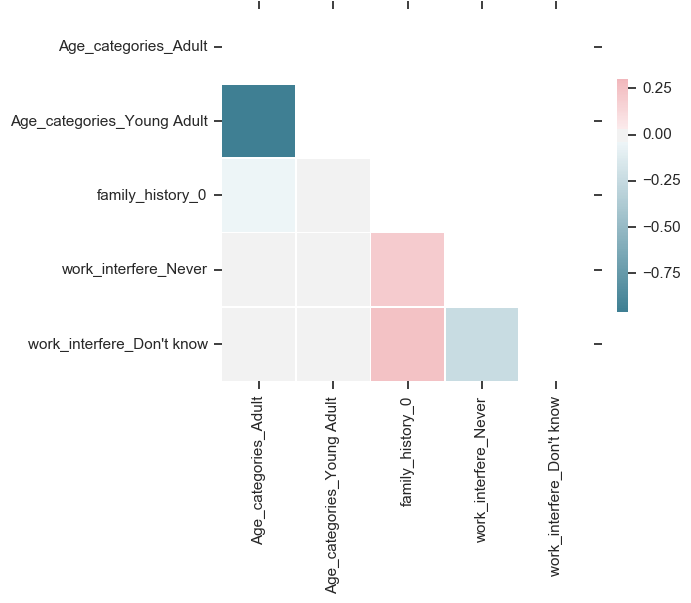

In [36]:
feature_cols = ordered_feature_importance.index[-5:]
X = survey[feature_cols]
y = survey.treatment
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
plot_correlation_heatmap(X_train)

In [13]:
#Encoding data
survey_original = survey.copy()
from sklearn import preprocessing
labelDict = {}
for feature in survey:
    le = preprocessing.LabelEncoder()
    le.fit(survey[feature])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    survey[feature] = le.transform(survey[feature])
    # Get labels
    labelKey = feature
    #labelValue = [*le_name_mapping]
    labelValue = le_name_mapping
    labelDict[labelKey] =labelValue
    
for key, value in labelDict.items():     
    print(key, value)

Country {'Romania': 35, 'United States': 45, 'Nigeria': 30, 'Thailand': 43, 'Zimbabwe': 47, 'Croatia': 11, 'Germany': 17, 'Moldova': 27, 'Uruguay': 46, 'Bosnia and Herzegovina': 4, 'Slovenia': 38, 'Greece': 18, 'South Africa': 39, 'Czech Republic': 12, 'Norway': 31, 'Spain': 40, 'Portugal': 34, 'Philippines': 32, 'France': 15, 'Belgium': 3, 'Latvia': 25, 'Singapore': 37, 'Japan': 24, 'Israel': 22, 'United Kingdom': 44, 'Finland': 14, 'Italy': 23, 'Bahamas, The': 2, 'Netherlands': 28, 'Poland': 33, 'Colombia': 9, 'Mexico': 26, 'Denmark': 13, 'Brazil': 5, 'Bulgaria': 6, 'Hungary': 19, 'Russia': 36, 'China': 8, 'New Zealand': 29, 'Georgia': 16, 'Canada': 7, 'Costa Rica': 10, 'India': 20, 'Australia': 0, 'Ireland': 21, 'Switzerland': 42, 'Sweden': 41, 'Austria': 1}
care_options {'Yes': 2, 'No': 0, 'Not sure': 1}
benefits {'Yes': 2, 'No': 1, "Don't know": 0}
Gender {'NaN': 2, 'Male': 1, 'Female': 0}
remote_work {'Yes': 1, 'No': 0}
supervisor {'Yes': 2, 'No': 0, 'Some of them': 1}
mental_hea

C:\Users\Ossama\Anaconda3-4.2.0\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


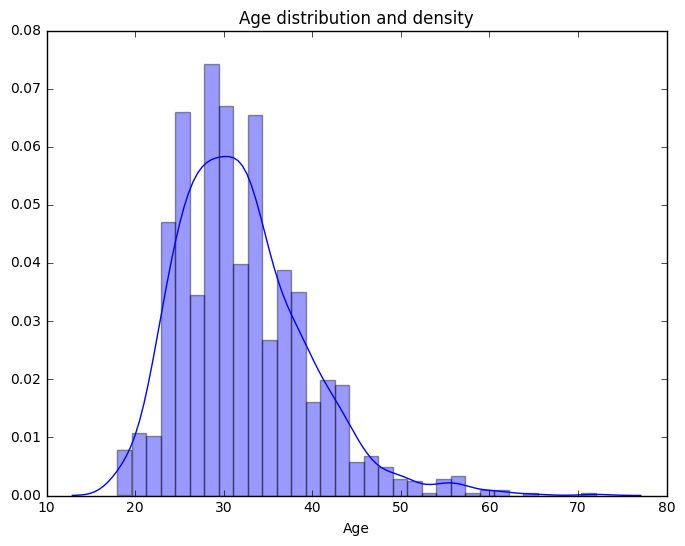

In [14]:
#survey.drop(['Country'], axis= 1, inplace = True)
plt.figure(figsize=(8,6))
sns.distplot(survey_original["Age"])
plt.title("Age distribution and density")
plt.xlabel("Age")
plt.show()

C:\Users\Ossama\Anaconda3-4.2.0\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


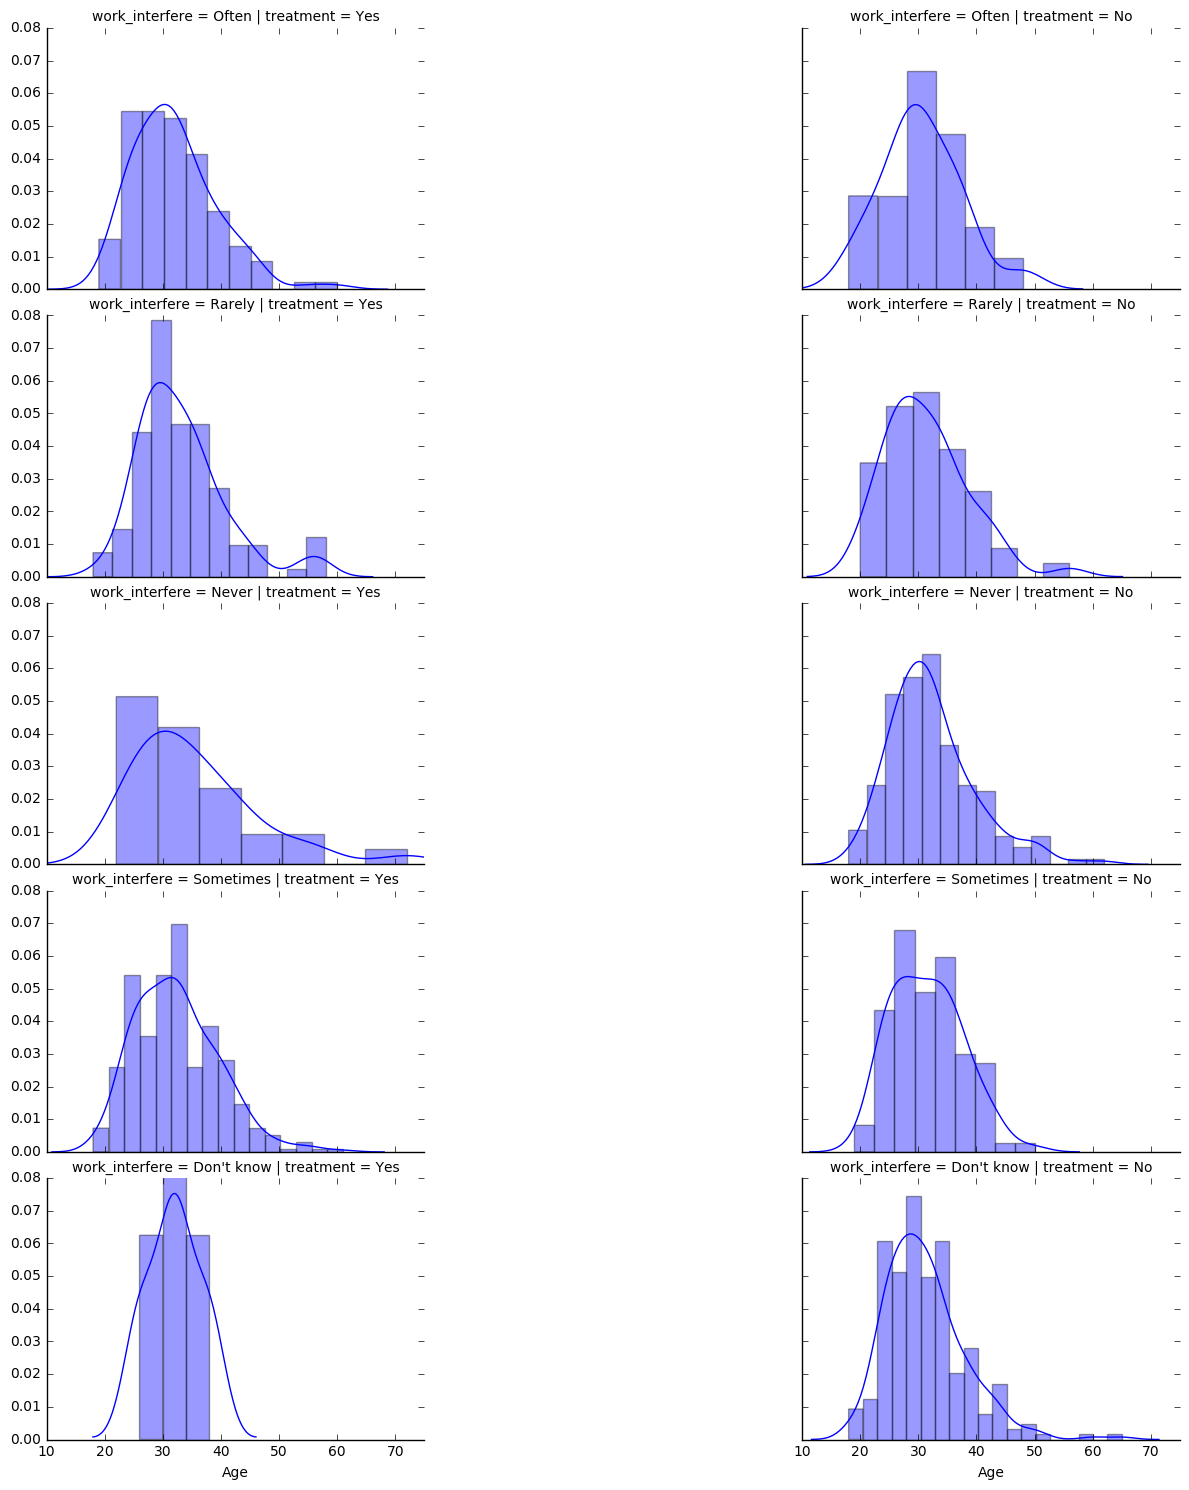

In [15]:
g = sns.FacetGrid(survey_original, col='treatment', row='work_interfere', height = 3 ,aspect =2,xlim=(10, 75), ylim=(0, .08))
g = g.map(sns.distplot, "Age").fig.subplots_adjust(wspace=1, hspace=.1)
#sns.despine()
plt.show()

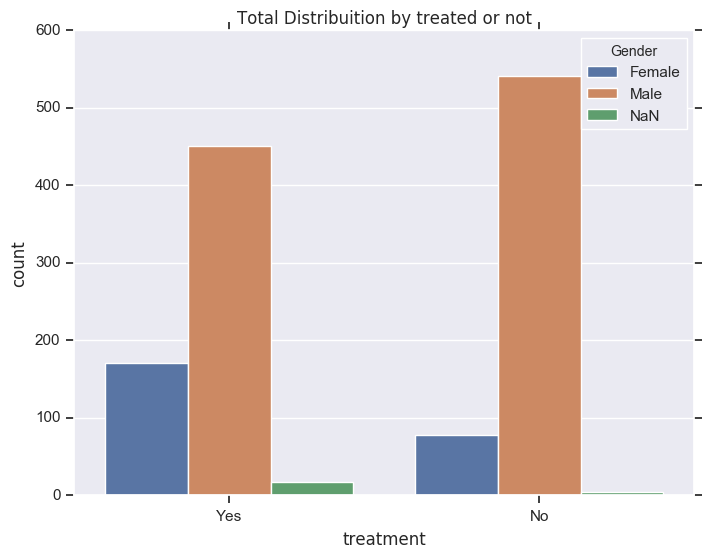

In [16]:
# Let see how many people has been treated
plt.figure(figsize=(8,6))
sns.set(style="darkgrid")
g = sns.countplot(x="treatment", data=survey_original, hue='Gender')
plt.title('Total Distribuition by treated or not')
plt.show()

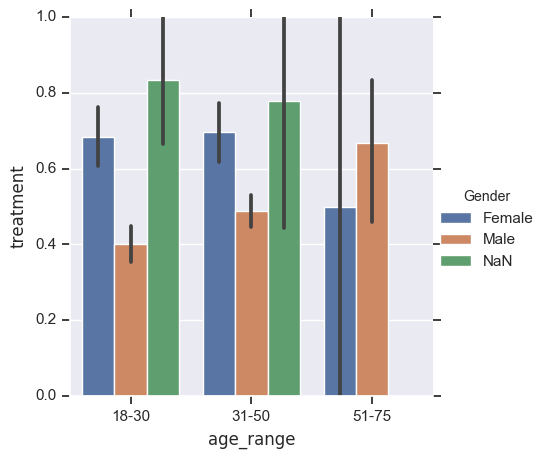

In [17]:
g = sns.catplot(x="age_range", y="treatment", hue="Gender", data=survey, kind="bar")
for h_label in g._legend.texts:
    for key, value in labelDict['Gender'].items():
        if h_label.get_text() == str(value):
            h_label.set_text(key)
x_labels = []
for i in range(0, len(labelDict['age_range'])):
    for key, value in labelDict['age_range'].items():
        if i == int(value):
            x_labels.append(key)
g.set_xticklabels(x_labels)
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

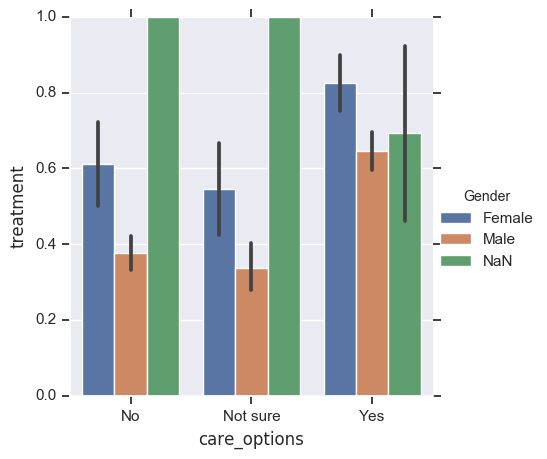

In [18]:
g = sns.catplot(x="care_options", y="treatment", hue="Gender", data=survey, kind="bar")
for h_label in g._legend.texts:
    for key, value in labelDict['Gender'].items():
        if h_label.get_text() == str(value):
            h_label.set_text(key)
x_labels = []
for i in range(0, len(labelDict['care_options'])):
    for key, value in labelDict['care_options'].items():
        if i == int(value):
            x_labels.append(key)
g.set_xticklabels(x_labels)
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

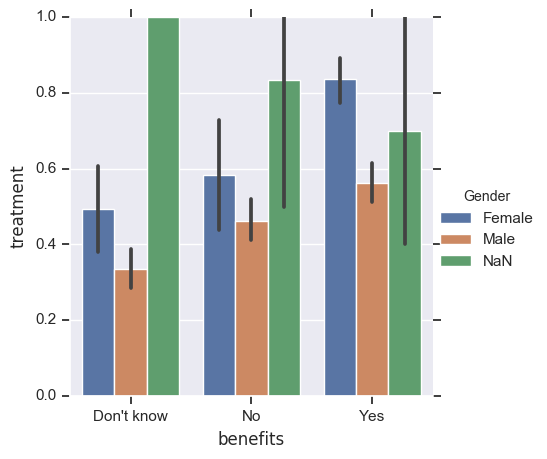

In [19]:
g = sns.catplot(x="benefits", y="treatment", hue="Gender", data=survey, kind="bar")
for h_label in g._legend.texts:
    for key, value in labelDict['Gender'].items():
        if h_label.get_text() == str(value):
            h_label.set_text(key)
x_labels = []
for i in range(0, len(labelDict['benefits'])):
    for key, value in labelDict['benefits'].items():
        if i == int(value):
            x_labels.append(key)
g.set_xticklabels(x_labels)
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

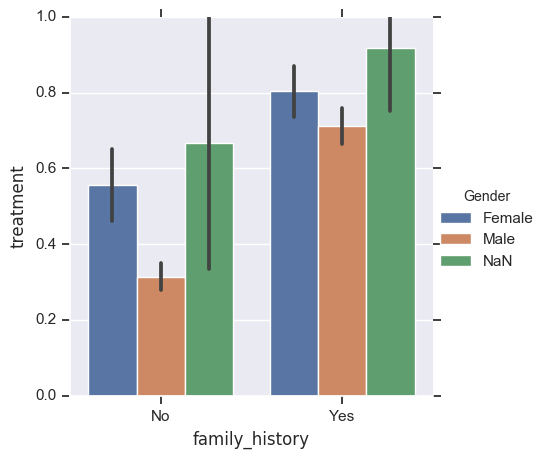

In [20]:
g = sns.catplot(x="family_history", y="treatment", hue="Gender", data=survey, kind="bar")
for h_label in g._legend.texts:
    for key, value in labelDict['Gender'].items():
        if h_label.get_text() == str(value):
            h_label.set_text(key)
x_labels = []
for i in range(0, len(labelDict['family_history'])):
    for key, value in labelDict['family_history'].items():
        if i == int(value):
            x_labels.append(key)
g.set_xticklabels(x_labels)
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

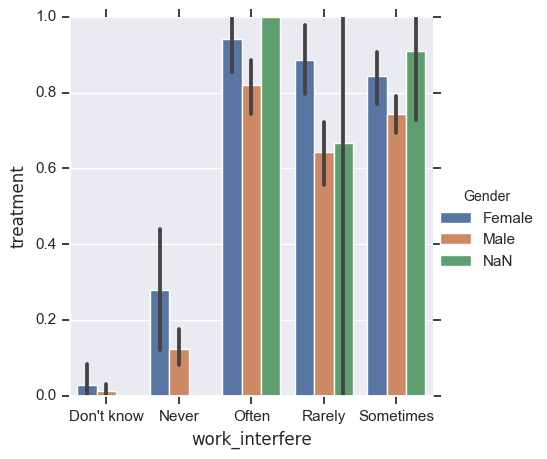

In [21]:
g = sns.catplot(x="work_interfere", y="treatment", hue="Gender", data=survey, kind="bar")
for h_label in g._legend.texts:
    for key, value in labelDict['Gender'].items():
        if h_label.get_text() == str(value):
            h_label.set_text(key)
x_labels = []
for i in range(0, len(labelDict['work_interfere'])):
    for key, value in labelDict['work_interfere'].items():
        if i == int(value):
            x_labels.append(key)
g.set_xticklabels(x_labels)
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

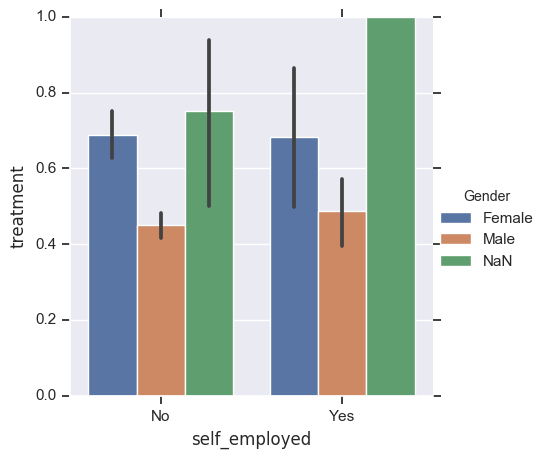

In [22]:
g = sns.catplot(x="self_employed", y="treatment", hue="Gender", data=survey, kind="bar")
for h_label in g._legend.texts:
    for key, value in labelDict['Gender'].items():
        if h_label.get_text() == str(value):
            h_label.set_text(key)
x_labels = []
for i in range(0, len(labelDict['self_employed'])):
    for key, value in labelDict['self_employed'].items():
        if i == int(value):
            x_labels.append(key)
g.set_xticklabels(x_labels)
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

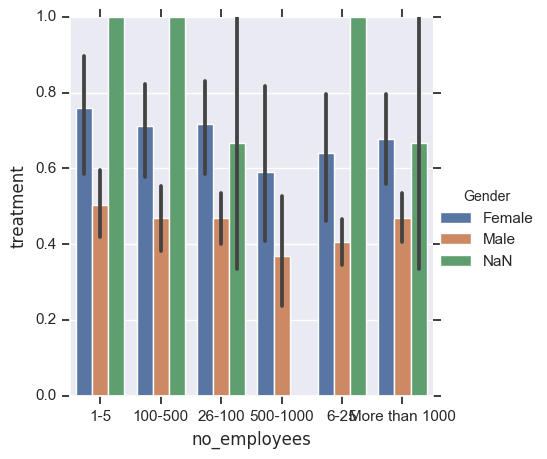

In [23]:
g = sns.catplot(x="no_employees", y="treatment", hue="Gender", data=survey, kind="bar")
for h_label in g._legend.texts:
    for key, value in labelDict['Gender'].items():
        if h_label.get_text() == str(value):
            h_label.set_text(key)
x_labels = []
for i in range(0, len(labelDict['no_employees'])):
    for key, value in labelDict['no_employees'].items():
        if i == int(value):
            x_labels.append(key)
g.set_xticklabels(x_labels)
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

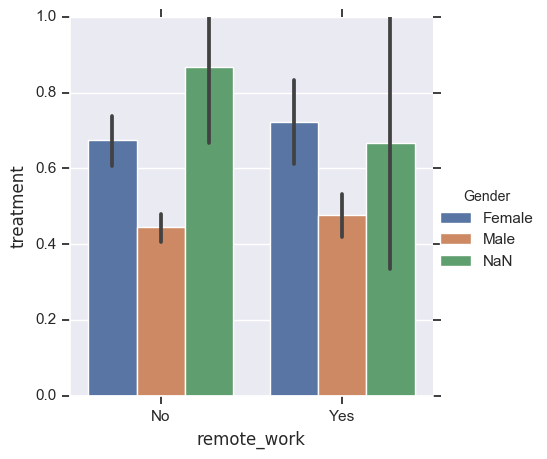

In [24]:
g = sns.catplot(x="remote_work", y="treatment", hue="Gender", data=survey, kind="bar")
for h_label in g._legend.texts:
    for key, value in labelDict['Gender'].items():
        if h_label.get_text() == str(value):
            h_label.set_text(key)
x_labels = []
for i in range(0, len(labelDict['remote_work'])):
    for key, value in labelDict['remote_work'].items():
        if i == int(value):
            x_labels.append(key)
g.set_xticklabels(x_labels)
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

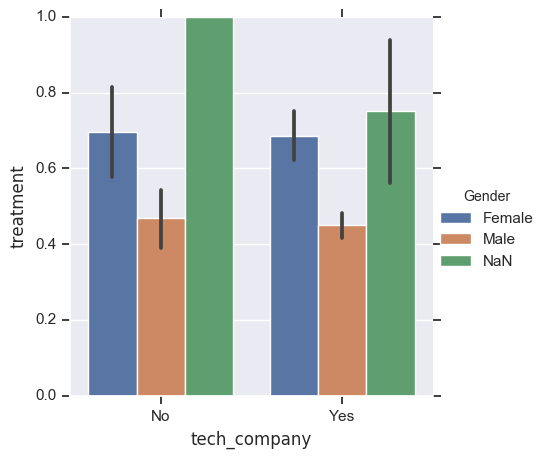

In [25]:
g = sns.catplot(x="tech_company", y="treatment", hue="Gender", data=survey, kind="bar")
for h_label in g._legend.texts:
    for key, value in labelDict['Gender'].items():
        if h_label.get_text() == str(value):
            h_label.set_text(key)
x_labels = []
for i in range(0, len(labelDict['tech_company'])):
    for key, value in labelDict['tech_company'].items():
        if i == int(value):
            x_labels.append(key)
g.set_xticklabels(x_labels)
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

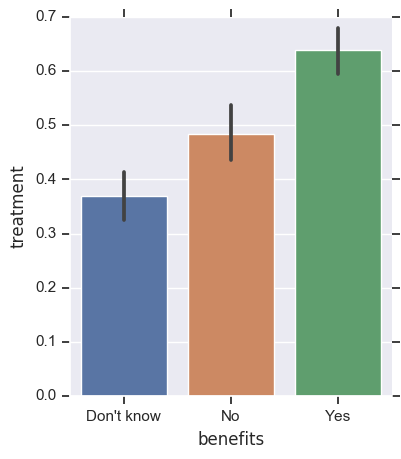

In [26]:
g = sns.catplot(x="benefits", y="treatment", data=survey, kind="bar")
#for h_label in g._legend.texts:
#    for key, value in labelDict['Gender'].items():
#        if h_label.get_text() == str(value):
#            h_label.set_text(key)
x_labels = []
for i in range(0, len(labelDict['benefits'])):
    for key, value in labelDict['benefits'].items():
        if i == int(value):
            x_labels.append(key)
g.set_xticklabels(x_labels)
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

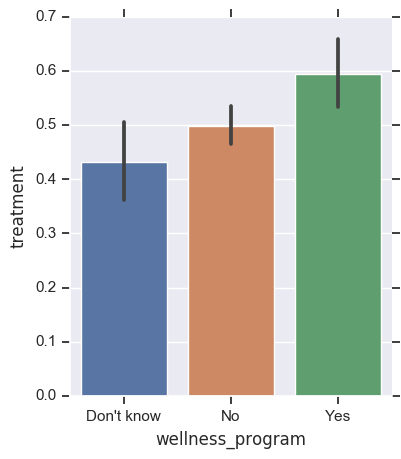

In [27]:
feature = 'wellness_program'
g = sns.catplot(x=feature, y="treatment", data=survey, kind="bar")
#for h_label in g._legend.texts:
#    for key, value in labelDict['Gender'].items():
#        if h_label.get_text() == str(value):
#            h_label.set_text(key)
x_labels = []
for i in range(0, len(labelDict[feature])):
    for key, value in labelDict[feature].items():
        if i == int(value):
            x_labels.append(key)
g.set_xticklabels(x_labels)
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

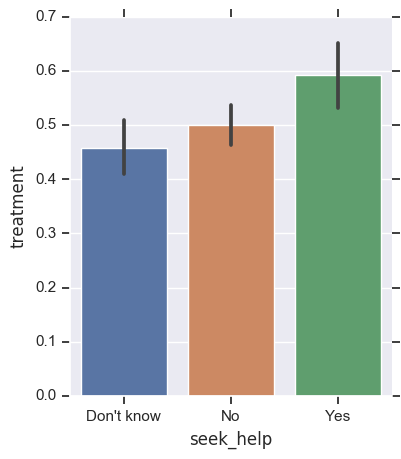

In [28]:
feature = 'seek_help'
g = sns.catplot(x=feature, y="treatment", data=survey, kind="bar")
#for h_label in g._legend.texts:
#    for key, value in labelDict['Gender'].items():
#        if h_label.get_text() == str(value):
#            h_label.set_text(key)
x_labels = []
for i in range(0, len(labelDict[feature])):
    for key, value in labelDict[feature].items():
        if i == int(value):
            x_labels.append(key)
g.set_xticklabels(x_labels)
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

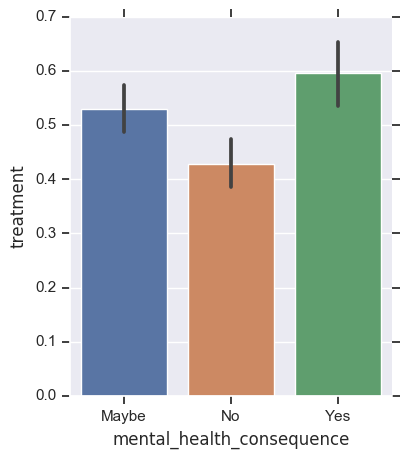

In [29]:
feature = 'mental_health_consequence'
g = sns.catplot(x=feature, y="treatment", data=survey, kind="bar")
#for h_label in g._legend.texts:
#    for key, value in labelDict['Gender'].items():
#        if h_label.get_text() == str(value):
#            h_label.set_text(key)
x_labels = []
for i in range(0, len(labelDict[feature])):
    for key, value in labelDict[feature].items():
        if i == int(value):
            x_labels.append(key)
g.set_xticklabels(x_labels)
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

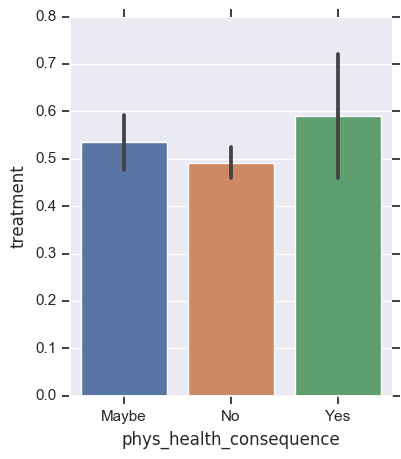

In [30]:
feature = 'phys_health_consequence'
g = sns.catplot(x=feature, y="treatment", data=survey, kind="bar")
#for h_label in g._legend.texts:
#    for key, value in labelDict['Gender'].items():
#        if h_label.get_text() == str(value):
#            h_label.set_text(key)
x_labels = []
for i in range(0, len(labelDict[feature])):
    for key, value in labelDict[feature].items():
        if i == int(value):
            x_labels.append(key)
g.set_xticklabels(x_labels)
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

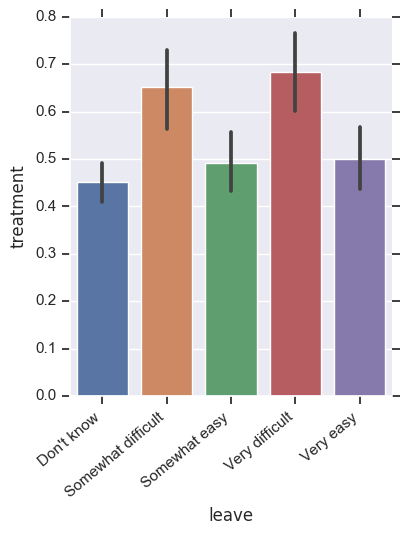

In [31]:
feature = 'leave'
g = sns.catplot(x=feature, y="treatment", data=survey, kind="bar")
#for h_label in g._legend.texts:
#    for key, value in labelDict['Gender'].items():
#        if h_label.get_text() == str(value):
#            h_label.set_text(key)
x_labels = []
for i in range(0, len(labelDict[feature])):
    for key, value in labelDict[feature].items():
        if i == int(value):
            x_labels.append(key)
g.set_xticklabels(x_labels,rotation=40, ha="right")
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

In [32]:
scaler = MinMaxScaler()
survey['Age'] = scaler.fit_transform(survey[['Age']])
survey.head()

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,0.431818,0,45,0,0,1,2,4,0,1,...,2,1,1,1,2,1,0,2,0,1
1,0.590909,1,45,0,0,0,3,5,0,0,...,0,0,1,0,0,1,1,0,0,1
2,0.318182,1,7,0,0,0,3,4,0,1,...,1,1,1,2,2,2,2,1,0,1
3,0.295455,1,44,0,1,1,2,2,0,1,...,1,2,2,1,0,0,0,1,1,1
4,0.295455,1,45,0,0,0,1,1,1,1,...,0,1,1,1,2,2,2,0,0,1


In [33]:
feature_cols = ['Age', 'Gender', 'family_history','work_interfere', 'care_options',\
                'benefits', 'wellness_program','anonymity', 'leave',\
                'mental_health_consequence', 'phys_health_consequence']
X = survey[feature_cols]
y = survey.treatment
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create dictionaries for final graph
# Use: methodDict['Stacking'] = accuracy_score
methodDict = {}
rmseDict = ()

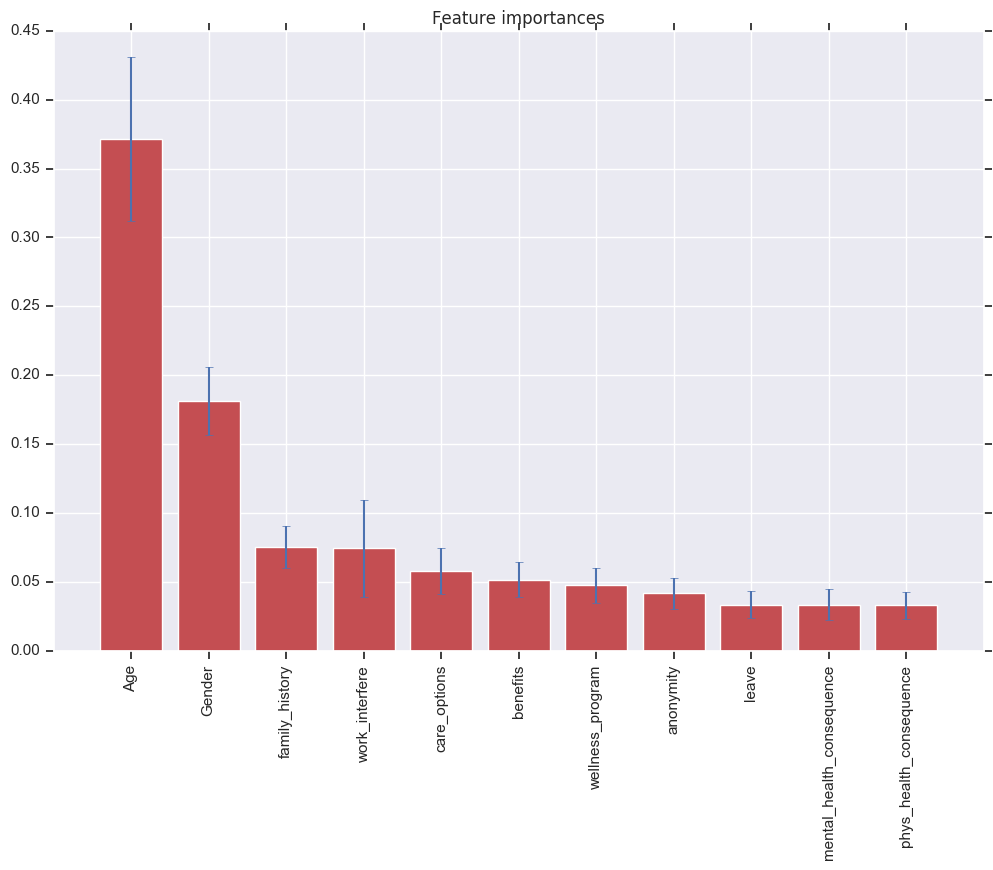

In [34]:
forest = RandomForestClassifier(n_estimators = 500, criterion = 'entropy', random_state = 0)
forest.fit(X_train, y_train)

# Predicting the Test set results
y_pred = forest.predict(X_test)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

labels = []
for f in range(X.shape[1]):
    labels.append(feature_cols[f])      
    
# Plot the feature importances of the forest
plt.figure(figsize=(12,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), labels, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

In [35]:
thresholds = np.sort(forest.feature_importances_)
for thresh in thresholds:
    # selecting features using threshold
    selection = SelectFromModel(forest, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    
    # training model
    selection_model = RandomForestClassifier(n_estimators = 500, criterion = 'entropy')
    selection_model.fit(select_X_train, y_train)
    
    # evaluating model
    select_X_test = selection.transform(X_test)
    pred_y = selection_model.predict(select_X_test)
    predictions = [round(value) for value in pred_y]
    accuracy = metrics.accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.033, n=11, Accuracy: 78.57%
Thresh=0.033, n=10, Accuracy: 80.16%
Thresh=0.033, n=9, Accuracy: 78.17%
Thresh=0.042, n=8, Accuracy: 77.38%
Thresh=0.047, n=7, Accuracy: 78.57%
Thresh=0.052, n=6, Accuracy: 78.17%
Thresh=0.058, n=5, Accuracy: 77.78%
Thresh=0.074, n=4, Accuracy: 76.59%
Thresh=0.075, n=3, Accuracy: 78.57%
Thresh=0.181, n=2, Accuracy: 78.17%
Thresh=0.371, n=1, Accuracy: 80.56%


In [36]:
def evalClassModel(model, y_test, y_pred_class, plot=False):
    #Classification accuracy: percentage of correct predictions
    # calculate accuracy
    print('Accuracy:', metrics.accuracy_score(y_test, y_pred_class))
    
    #Null accuracy: accuracy that could be achieved by always predicting the most frequent class
    # examine the class distribution of the testing set (using a Pandas Series method)
    print('Null accuracy: \n', y_test.value_counts())
    
    # calculate the percentage of ones
    print('Percentage of ones: %.0f%%' % (y_test.mean()*100) )
    
    percentage_zeros = 100 - y_test.mean()*100
    # calculate the percentage of zeros
    print('Percentage of zeros: %.0f%%' % percentage_zeros  )
    
    
    #Conclusion:
    #Classification accuracy is the easiest classification metric to understand
    #But, it does not tell you the underlying distribution of response values
    #And, it does not tell you what "types" of errors your classifier is making
    
    #Confusion matrix
    # save confusion matrix and slice into four pieces
    confusion = metrics.confusion_matrix(y_test, y_pred_class)
    #[row, column]
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    
    # visualize Confusion Matrix
    sns.heatmap(confusion,annot=True,fmt="d") 
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    #Metrics computed from a confusion matrix
    #Classification Accuracy: Overall, how often is the classifier correct?
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    print('Classification Accuracy:', accuracy)
    
    #Classification Error: Overall, how often is the classifier incorrect?
    print('Classification Error:', 1 - metrics.accuracy_score(y_test, y_pred_class))
    
    #False Positive Rate: When the actual value is negative, how often is the prediction incorrect?
    false_positive_rate = FP / float(TN + FP)
    print('False Positive Rate: %.0f%%' % (false_positive_rate*100) )
    
    #Precision: When a positive value is predicted, how often is the prediction correct?
    print('Precision:', metrics.precision_score(y_test, y_pred_class))
    
    
    # IMPORTANT: first argument is true values, second argument is predicted probabilities
    print('AUC Score:', metrics.roc_auc_score(y_test, y_pred_class))
    
    # calculate cross-validated AUC
    print('Cross-validated AUC:', cross_val_score(model, X, y, cv=10, scoring='roc_auc').mean())
    
    ##########################################
    #Adjusting the classification threshold
    ##########################################
    # print the first 10 predicted responses
    # 1D array (vector) of binary values (0, 1)
    print('First 10 predicted responses:\n', model.predict(X_test)[0:10])

    # print the first 10 predicted probabilities of class membership
    print('First 10 predicted probabilities of class members:\n', model.predict_proba(X_test)[0:10])

    # print the first 10 predicted probabilities for class 1
    model.predict_proba(X_test)[0:10, 1]
    
    # store the predicted probabilities for class 1
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    if plot == True:
        # histogram of predicted probabilities
        # adjust the font size 
        plt.rcParams['font.size'] = 12
        # 8 bins
        plt.hist(y_pred_prob, bins=8)
        
        # x-axis limit from 0 to 1
        plt.xlim(0,1)
        plt.title('Histogram of predicted probabilities')
        plt.xlabel('Predicted probability of treatment')
        plt.ylabel('Frequency')
    
    
    # predict treatment if the predicted probability is greater than 0.3
    # it will return 1 for all values above 0.3 and 0 otherwise
    # results are 2D so we slice out the first column
    y_pred_prob = y_pred_prob.reshape(-1,1) 
    y_pred_class = binarize(y_pred_prob, 0.3)[0]
    
    # print the first 10 predicted probabilities
    print('First 10 predicted probabilities:\n', y_pred_prob[0:10])
    
    ##########################################
    #ROC Curves and Area Under the Curve (AUC)
    ##########################################
    
    #Question: Wouldn't it be nice if we could see how sensitivity and specificity are affected by various thresholds, without actually changing the threshold?
    #Answer: Plot the ROC curve!
    
    
    #AUC is the percentage of the ROC plot that is underneath the curve
    #Higher value = better classifier
    roc_auc = metrics.roc_auc_score(y_test, y_pred_prob)
    
    

    # IMPORTANT: first argument is true values, second argument is predicted probabilities
    # we pass y_test and y_pred_prob
    # we do not use y_pred_class, because it will give incorrect results without generating an error
    # roc_curve returns 3 objects fpr, tpr, thresholds
    # fpr: false positive rate
    # tpr: true positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
    if plot == True:
        plt.figure()
        
        plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('ROC curve for treatment classifier')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.show()
    
    # define a function that accepts a threshold and prints sensitivity and specificity
    def evaluate_threshold(threshold):
        #Sensitivity: When the actual value is positive, how often is the prediction correct?
        #Specificity: When the actual value is negative, how often is the prediction correct?print('Sensitivity for ' + str(threshold) + ' :', tpr[thresholds > threshold][-1])
        print('Specificity for ' + str(threshold) + ' :', 1 - fpr[thresholds > threshold][-1])

    # One way of setting threshold
    predict_mine = np.where(y_pred_prob > 0.50, 1, 0)
    confusion = metrics.confusion_matrix(y_test, predict_mine)
    print(confusion)
    
    
    
    return accuracy

########### Logistic Regression ###############
Accuracy: 0.785714285714
Null accuracy: 
 0    134
1    118
Name: treatment, dtype: int64
Percentage of ones: 47%
Percentage of zeros: 53%


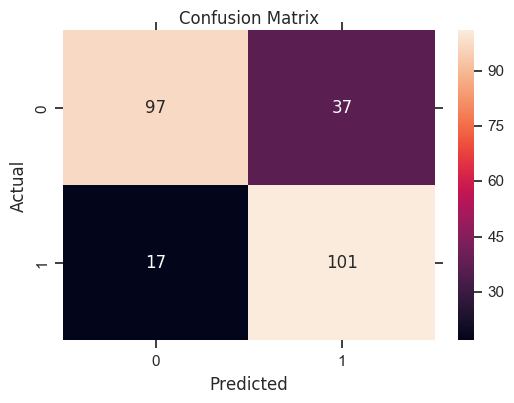

Classification Accuracy: 0.785714285714
Classification Error: 0.214285714286
False Positive Rate: 28%
Precision: 0.731884057971
AUC Score: 0.789906400202
Cross-validated AUC: 0.873253088198
First 10 predicted responses:
 [1 0 0 1 1 1 0 1 0 0]
First 10 predicted probabilities of class members:
 [[ 0.0790492   0.9209508 ]
 [ 0.94116644  0.05883356]
 [ 0.95163579  0.04836421]
 [ 0.16687204  0.83312796]
 [ 0.40491685  0.59508315]
 [ 0.06494732  0.93505268]
 [ 0.78496221  0.21503779]
 [ 0.21765028  0.78234972]
 [ 0.55830699  0.44169301]
 [ 0.52027214  0.47972786]]
First 10 predicted probabilities:
 [[ 0.9209508 ]
 [ 0.05883356]
 [ 0.04836421]
 [ 0.83312796]
 [ 0.59508315]
 [ 0.93505268]
 [ 0.21503779]
 [ 0.78234972]
 [ 0.44169301]
 [ 0.47972786]]


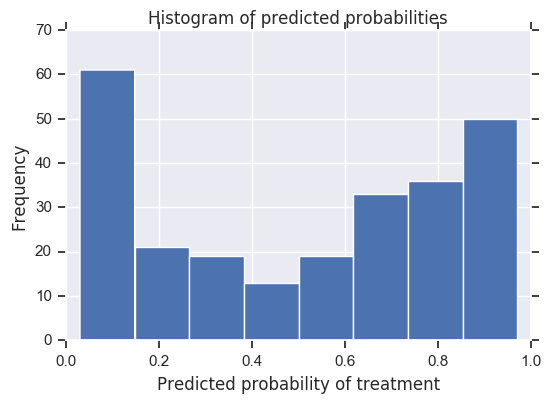

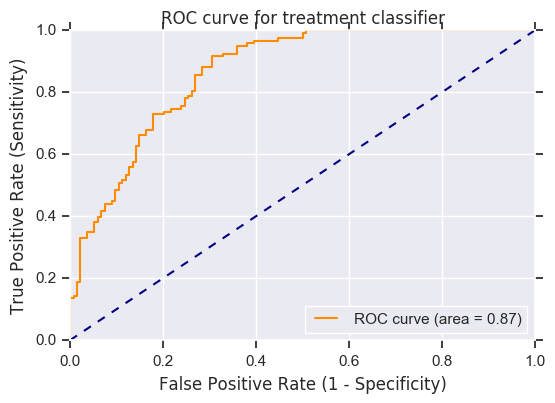

[[ 97  37]
 [ 17 101]]


In [37]:
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)

# make class predictions for the testing set
y_pred_class = logreg.predict(X_test)

print('########### Logistic Regression ###############')

accuracy_score = evalClassModel(logreg, y_test, y_pred_class, True)

#Data for final graph
methodDict['Log. Regres.'] = accuracy_score * 100

########### Random Forest Regression ###############
Accuracy: 0.785714285714
Null accuracy: 
 0    134
1    118
Name: treatment, dtype: int64
Percentage of ones: 47%
Percentage of zeros: 53%


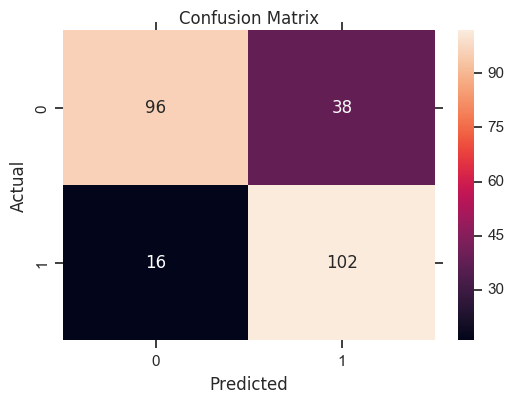

Classification Accuracy: 0.785714285714
Classification Error: 0.214285714286
False Positive Rate: 28%
Precision: 0.728571428571
AUC Score: 0.790412345054
Cross-validated AUC: 0.88094078021
First 10 predicted responses:
 [1 0 0 1 0 1 0 1 1 1]
First 10 predicted probabilities of class members:
 [[ 0.104  0.896]
 [ 0.996  0.004]
 [ 0.994  0.006]
 [ 0.208  0.792]
 [ 0.508  0.492]
 [ 0.22   0.78 ]
 [ 0.956  0.044]
 [ 0.404  0.596]
 [ 0.07   0.93 ]
 [ 0.118  0.882]]
First 10 predicted probabilities:
 [[ 0.896]
 [ 0.004]
 [ 0.006]
 [ 0.792]
 [ 0.492]
 [ 0.78 ]
 [ 0.044]
 [ 0.596]
 [ 0.93 ]
 [ 0.882]]


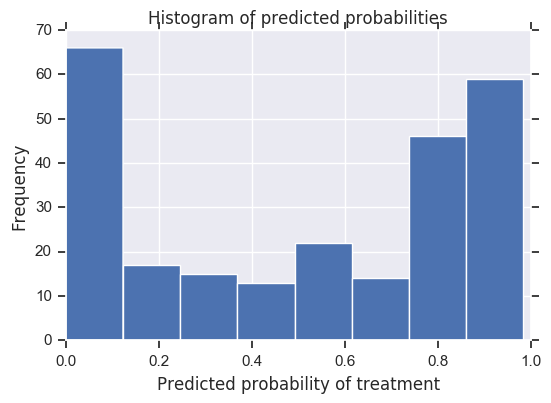

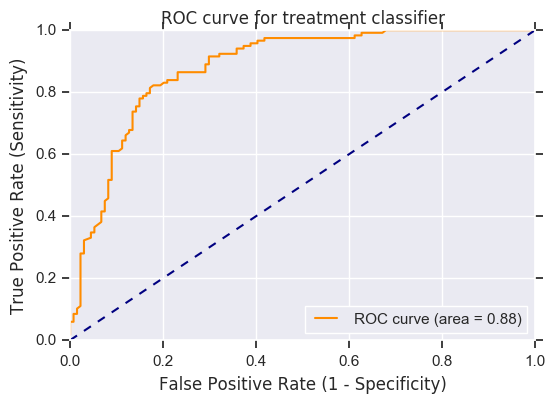

[[ 96  38]
 [ 16 102]]


In [38]:
y_pred_class = forest.predict(X_test)

print('########### Random Forest Regression ###############')

accuracy_score = evalClassModel(forest, y_test, y_pred_class, True)

In [63]:
missing_values_per_column = survey.isnull().sum().sort_values(ascending=False)
percentage_missing_values = 100*(survey.isnull().sum()/survey.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([missing_values_per_column, percentage_missing_values], \
                         axis=1, keys=['Number of missing values', 'Percentage of missing values'])
missing_data['Percentage of missing values'] = pd.Series(["{0:.2f}%".format(val) for val in missing_data['Percentage of missing values']],\
                                                        index = missing_data.index)
missing_data

,Number of missing values,Percentage of missing values
age_range,0,0.00%
care_options,0,0.00%
Gender,0,0.00%
Country,0,0.00%
self_employed,0,0.00%
family_history,0,0.00%
treatment,0,0.00%
work_interfere,0,0.00%
no_employees,0,0.00%
remote_work,0,0.00%


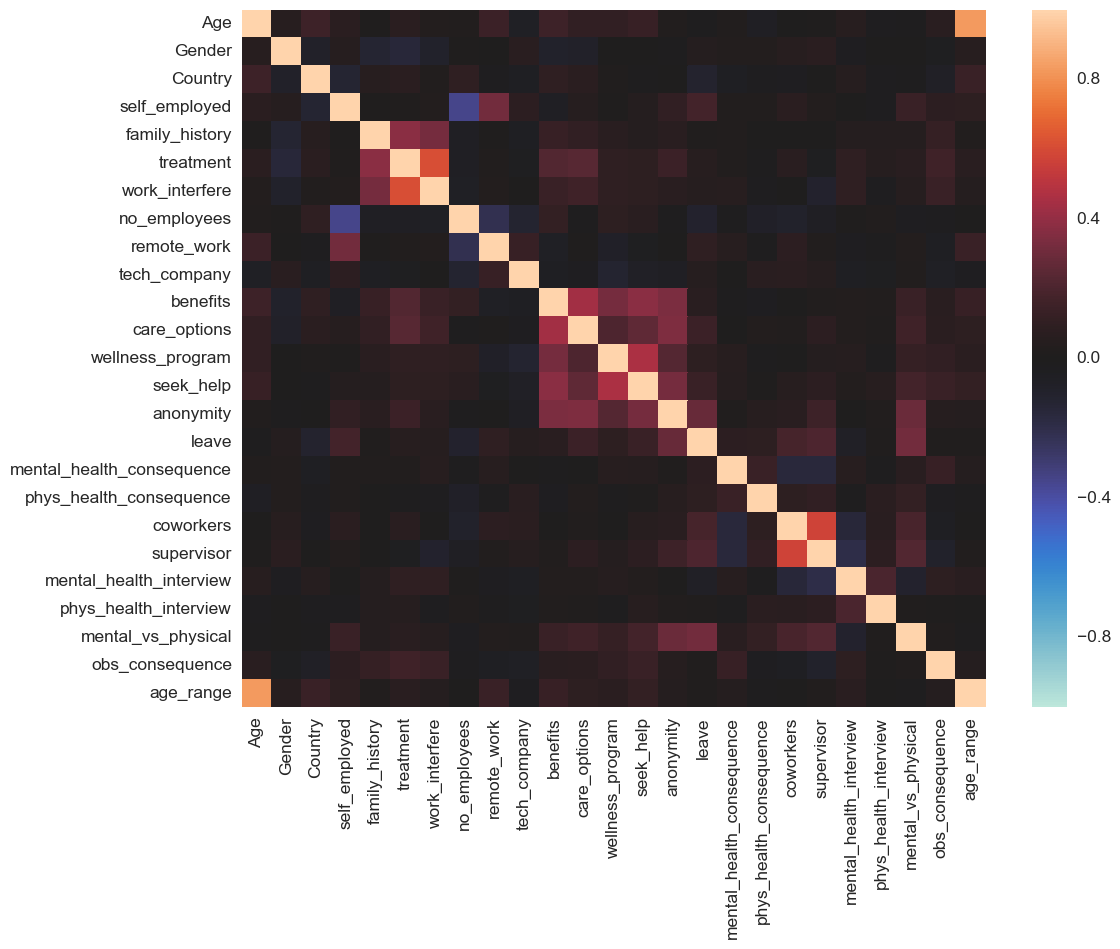

In [64]:
corrmat = survey.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmin = -1, vmax = 1, center = 0)
plt.show()

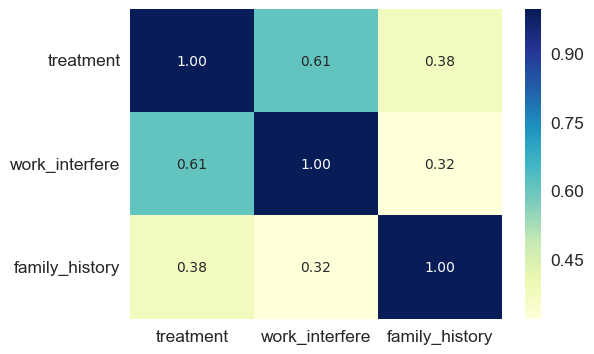

In [65]:
k = 3 #number of variables for heatmap
cols = corrmat.nlargest(k, 'treatment')['treatment'].index
cm = np.corrcoef(survey[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True,cmap="YlGnBu", fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [24]:
g.ax.get_xlabels()

AttributeError: 'AxesSubplot' object has no attribute 'get_xlabels'

In [27]:
labelDict['tech_company']

{'No': 0, 'Yes': 1}

In [14]:
 survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 25 columns):
Age                          1259 non-null int64
Gender                       1259 non-null int32
Country                      1259 non-null int32
self_employed                1259 non-null int32
family_history               1259 non-null int32
treatment                    1259 non-null int32
work_interfere               1259 non-null int32
no_employees                 1259 non-null int32
remote_work                  1259 non-null int32
tech_company                 1259 non-null int32
benefits                     1259 non-null int32
care_options                 1259 non-null int32
wellness_program             1259 non-null int32
seek_help                    1259 non-null int32
anonymity                    1259 non-null int32
leave                        1259 non-null int32
mental_health_consequence    1259 non-null int32
phys_health_consequence      1259 non-null int32
coworkers  